In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')


1 Physical GPUs, 1 Logical GPU


In [5]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [6]:
data_dir = Path('/content/drive/MyDrive/dacon/input')
feature_dir = Path('../build/feature')
val_dir = Path('/content/drive/MyDrive/dacon/build/val')
tst_dir = Path('/content/drive/MyDrive/dacon/build/tst')
sub_dir = Path('/content/drive/MyDrive/dacon/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [7]:
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [8]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [9]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [10]:
train[train['text'].str.contains("_")]

,text,author
index,,
44,"“_Au revoir_,” said our visitor, and, with a b...",2
77,"“_What?_” cried Mrs. odin, raising her hands i...",3
115,“In marriage especially. With all due respect ...,1
121,“And how are _you_?” said Miss odin to Camilla...,0
145,It’s long—eight centuries—since we have been ...,3
...,...,...
54669,“Hum! There’s a flaw there. Let us apply commo...,2
54789,“I am sure _I_ know none so handsome; but in ...,1
54805,A huge black tree trunk was coming down the ri...,2


In [11]:
train['text'] = train['text'].str.replace('\?',' quesmark ')
train['text'] = train['text'].str.replace('\!',' exclmark ')
train['text'] = train['text'].str.replace('\&',' empent ')
train['text'] = train['text'].str.replace("\*",' chstar ')
train['text'] = train['text'].str.replace(";",' smcolons  ')

test['text'] = test['text'].str.replace('\?',' quesmark ')
test['text'] = test['text'].str.replace('\!',' exclmark ')
test['text'] = test['text'].str.replace('\&',' empent ')
test['text'] = test['text'].str.replace("\*",' chstar ')
test['text'] = test['text'].str.replace(";",' smcolons  ')

In [12]:
train['text']=train['text'].str.replace('\'s', '')
train['text']=train['text'].str.replace('’s', '')
train['text']=train['text'].str.replace('\'ll', '')
train['text']=train['text'].str.replace('’ll', '')
train['text']=train['text'].str.replace("\'", '')
train['text']=train['text'].str.replace("’", '')

test['text']=test['text'].str.replace("’s",'')
test['text']=test['text'].str.replace("\'s",'')
test['text']=test['text'].str.replace('\'ll', '')
test['text']=test['text'].str.replace('’ll', '')
test['text']=test['text'].str.replace("\'", '')
test['text']=test['text'].str.replace("’", '')


In [13]:
train['text']=train['text'].str.replace('á', ' Ascenda ')
train['text']=train['text'].str.replace('à', ' Descenda ')
train['text']=train['text'].str.replace('â', ' Stremama ')
train['text']=train['text'].str.replace('ä', ' Doublea ')
train['text']=train['text'].str.replace('é', ' Ascende ')
train['text']=train['text'].str.replace('í', ' Justi ')
train['text']=train['text'].str.replace('ï', ' Doublei ')
train['text']=train['text'].str.replace('ó', ' Comao ')
train['text']=train['text'].str.replace('ú', ' Ascendu ')
train['text']=train['text'].str.replace('ý', ' Ascendy ')
train['text']=train['text'].str.replace('ü', ' Umlaut ')
train['text']=train['text'].str.replace('è', ' Descende ')
train['text']=train['text'].str.replace('£', ' Maludf ')

test['text']=test['text'].str.replace('ä', ' Doublea ')
test['text']=test['text'].str.replace('â', ' Stremama ')
test['text']=test['text'].str.replace('à', ' Descenda ')
test['text']=test['text'].str.replace('á', ' Ascenda ')
test['text']=test['text'].str.replace('é', ' Ascende ')
test['text']=test['text'].str.replace('ï', ' Doublei ')
test['text']=test['text'].str.replace('í', ' Justi ')
test['text']=test['text'].str.replace('ó', ' Comao  ')
test['text']=test['text'].str.replace('ú', ' Ascendu ')
test['text']=test['text'].str.replace('ý', ' Ascendy ')
test['text']=test['text'].str.replace('ü', ' Umalut ')
test['text']=test['text'].str.replace('è', ' Descende ')
test['text']=test['text'].str.replace('£', ' Maludf ')

In [16]:
def alpha_num(text):
    return re.sub("\d+", ' num ', text)

train['text']=train['text'].apply(alpha_num)
test['text']=test['text'].apply(alpha_num)

In [17]:
train['text']=train['text'].str.replace('\(', ' \( ')
train['text']=train['text'].str.replace('\{', ' \{ ')
train['text']=train['text'].str.replace('\[', ' \[ ')
train['text']=train['text'].str.replace('\)', ' \) ')
train['text']=train['text'].str.replace('\}', ' \} ')
train['text']=train['text'].str.replace('\]', ' \] ')
train['text']=train['text'].str.replace('—', '')
train['text']=train['text'].str.replace('_', '')
train['text']=train['text'].str.replace(':', '')

test['text']=test['text'].str.replace('\(', ' \( ')
test['text']=test['text'].str.replace('\{', ' \{ ')
test['text']=test['text'].str.replace('\[', ' \[ ')
test['text']=test['text'].str.replace('\)', ' \) ')
test['text']=test['text'].str.replace('\}', ' \} ')
test['text']=test['text'].str.replace('\]', ' \] ')
test['text']=test['text'].str.replace('—', '')
test['text']=test['text'].str.replace('_', '')
test['text']=test['text'].str.replace(':', '')

In [18]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

def lemma_text(text):
    tokenizer=TweetTokenizer()
    words=tokenizer.tokenize(text)
    lem = WordNetLemmatizer()
    words=[lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(lemma_text)
test['text'] = test['text'].str.lower().apply(lemma_text)

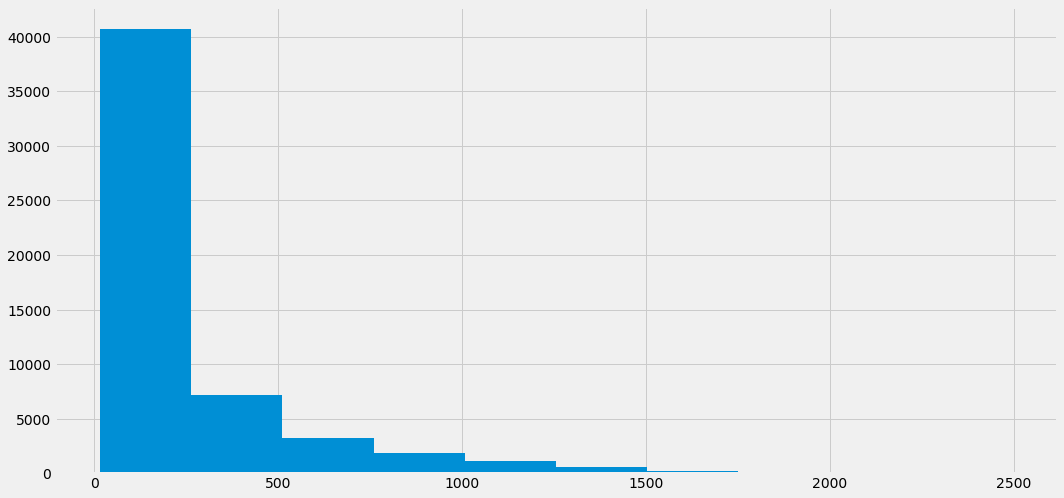

In [20]:
train['text'].str.len().hist()

In [22]:
X_trn = train['text'].values
X_tst = test['text'].values
y = train['author'].values
print(X_trn.shape, X_tst.shape, y.shape)

(54879,) (19617,) (54879,)


In [23]:
vocab_size = 21000
embedding_dim = 128
max_length = 460
padding_type='post'

In [24]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_trn)
word_index = tokenizer.word_index

In [25]:

train_sequences = tokenizer.texts_to_sequences(X_trn)
test_sequences = tokenizer.texts_to_sequences(X_tst)

In [26]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 460) (19617, 460)


In [27]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [28]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.2),
        Conv1D(256, 3, padding='valid', activation='relu', strides=1),  
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [29]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=256,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
172/172 [==============================] - 15s 86ms/step - loss: 0.9523 - val_loss: 0.6648
Epoch 2/10
172/172 [==============================] - 14s 84ms/step - loss: 0.5233 - val_loss: 0.6060
Epoch 3/10
172/172 [==============================] - 15s 84ms/step - loss: 0.3665 - val_loss: 0.6450
Epoch 4/10
172/172 [==============================] - 14s 84ms/step - loss: 0.2800 - val_loss: 0.7191
Epoch 5/10
172/172 [==============================] - 14s 84ms/step - loss: 0.2252 - val_loss: 0.8045
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
172/172 [==============================] - 15s 84ms/step - loss: 0.9491 - val_loss: 0.6543
Epoch 2/10
172/172 [==============================] - 14s 84ms/step - loss: 0.5274 - val_loss: 0.5875
Epoch 3/10
172/172 [==============================] - 14s 83ms/step - loss: 0.3670 - val_loss: 0.6430
Epoch 4/10
172/172 [==============================] - 14s 84ms/step - loss: 0.2799 - val_loss: 0.6972
Epoc

In [30]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')


Accuracy (CV):  77.9570%
Log Loss (CV):   0.6028


In [31]:

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [32]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [33]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0323,0.4789,0.4312,0.0553,0.0023
1,0.2083,0.1679,0.0587,0.3556,0.2095
2,0.9877,0.0094,0.0015,0.0002,0.0012
3,0.0480,0.0086,0.7988,0.0124,0.1322
4,0.5920,0.0170,0.1148,0.1457,0.1306


In [34]:
sub.to_csv(sub_file)